## 🌟 **Welcome to Lesson 04!** 🌟

### **What are Batches and Mini Batches? 🍪🍪**

In this lesson, we'll explore the concepts of batches and mini batches in depth. Why use them? How is training on batches even diffent than training on the whole Training data set? And how does using batches impact the training and performance of our models?

### **Detailed Examination 🔍**

We'll start with a detailed explination of batches and mini batches. We'll cover:

- **Definitions** 📖: Understanding what batches and mini batches are.
- **Benefits** 💡: Why they are crucial in training deep learning models.
- **Challenges** 🚧: The potential issues and how to overcome them.

<span style="color:pink;"> **READ THE 04lesson PDF FOR THE IN DEPTH EXPLINATION** </span>

### **Coding Example 💻**

We will be using the same EEG data. 


We'll implement two models to put theory into practice:

1. **Model 1**: Trained using mini batching.
2. **Model 2**: Trained using the entire training set.

We'll evaluate which model performs better at identifying the state (REM, wakeful, deep) of a 10-second long segment of data.
Our data comes from **rats** 🐀 and includes 10-second long segments that are classified into one of three states: REM, wakeful, or deep sleep.

Ready to dive in? Let's get started! 🚀


In [5]:
import torch
from torch import nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from torch.utils.data import DataLoader, TensorDataset


In [3]:
DATA_FOLDER = './../data/rat_eeg'


files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.pt')]

all_data = []
for file in files:
    path = os.path.join(DATA_FOLDER, file)
    data = torch.load(path)
    all_data.append((data[0], data[1]))

# split  into train and test sets
train_data, test_data = train_test_split(all_data, test_size=2/6, random_state=42)

# concat to creat full set
X_train = torch.cat([data[0] for data in train_data])
y_train = torch.cat([data[1] for data in train_data])

X_test = torch.cat([data[0] for data in test_data])
y_test = torch.cat([data[1] for data in test_data])

print(f"Training  X: {X_train.shape}")
print(f"Training  y: {y_train.shape}\n")

print(f"Test X: {X_test.shape}")
print(f"Test y: {y_test.shape}")


Training  X: torch.Size([34560, 1000])
Training  y: torch.Size([34560, 3])

Test X: torch.Size([17280, 1000])
Test y: torch.Size([17280, 3])


### **Using Mr. Iron Man from the Previous Lesson** 🦾

We'll use Mr. Iron Man from the previous lesson. 

In [6]:
class IRONMAN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(IRONMAN, self).__init__()
        self.l0 = nn.Linear(1000, 256)
        self.relu0 = nn.ReLU()
        self.dropout0 = nn.Dropout(dropout_rate)
        
        self.l1 = nn.Linear(256, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.l2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.l3 = nn.Linear(32, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.l4 = nn.Linear(32, 32)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.l5 = nn.Linear(32, 32)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(dropout_rate)

        self.l6 = nn.Linear(32, 3)
        self.out = nn.Sigmoid()

    def forward(self, X):
        x = self.dropout0(self.relu0(self.l0(X)))
        x = self.dropout1(self.relu1(self.l1(x)))
        x = self.dropout2(self.relu2(self.l2(x)))
        x = self.dropout3(self.relu3(self.l3(x)))
        x = self.dropout4(self.relu4(self.l4(x)))
        x = self.dropout5(self.relu5(self.l5(x)))
        logits = self.l6(x)
        x = self.out(logits)
        return x


ironman = IRONMAN()
optimizer = torch.optim.AdamW(params=ironman.parameters(), lr=0.0003, weight_decay=0.02)
criterion = nn.CrossEntropyLoss()

100%|██████████| 200/200 [00:45<00:00,  4.35it/s]


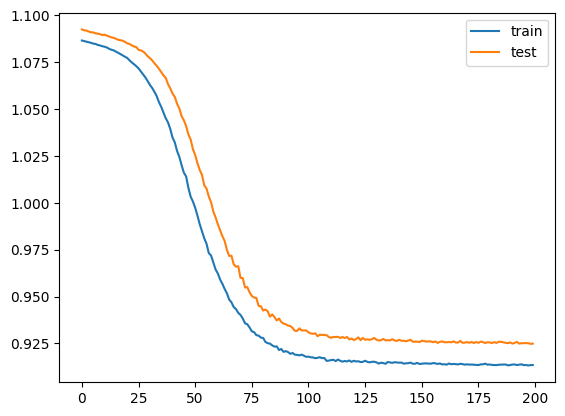

In [7]:
lossi = []
devlossi = []
f1 = []
devf1 = []

for epoch in tqdm(range(200)):
    out = ironman.forward(X_train)

    optimizer.zero_grad()
    loss = criterion(out, y_train)

    loss.backward()
    lossi.append(loss.item())
    optimizer.step()
    
    with torch.no_grad():
        devout = ironman.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")



              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1075
           1       0.49      0.62      0.55      8122
           2       0.48      0.41      0.44      8083

    accuracy                           0.48     17280
   macro avg       0.32      0.34      0.33     17280
weighted avg       0.45      0.48      0.46     17280



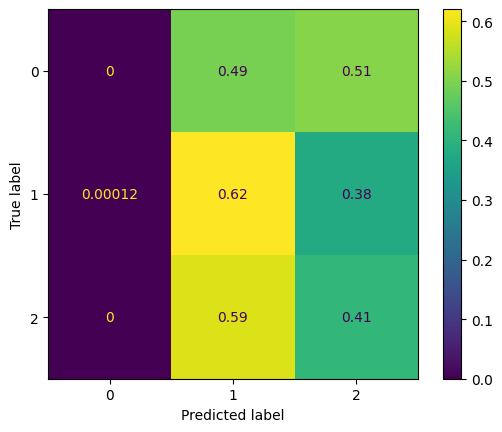

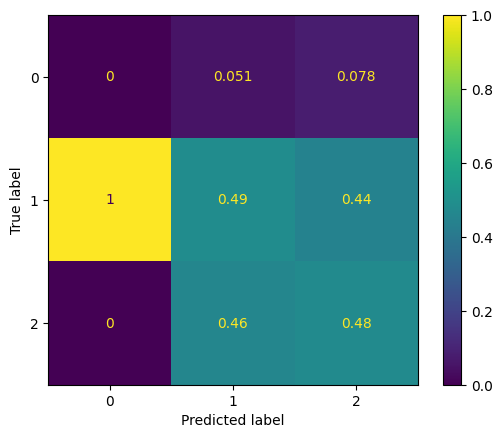

In [9]:
with torch.no_grad():
    y_pred = ironman.forward(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');


print(classification_report(y_true=y_true, y_pred=y_pred));


Now, let's reinitialize the model and train it again, but this time we will use batch sizes of 64. Let's see what happens!

In [15]:
ironman = IRONMAN()
optimizer = torch.optim.AdamW(params=ironman.parameters(), lr=0.0003, weight_decay=0.02)
criterion = nn.CrossEntropyLoss()

100%|██████████| 200/200 [03:46<00:00,  1.13s/it]


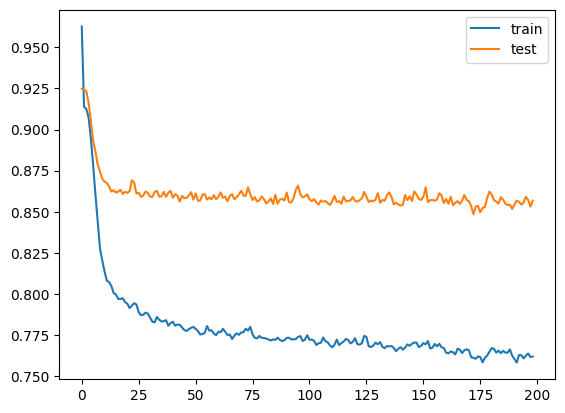

In [16]:
lossi = []
devlossi = []

train_dataset = TensorDataset(X_train, y_train)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm(range(200)):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        out = ironman.forward(X_batch)
        
        optimizer.zero_grad()
        loss = criterion(out, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    lossi.append(epoch_loss / len(train_loader))  # append avg loss per epoch

    with torch.no_grad():
        devout = ironman.forward(X_test)
        devloss  = criterion(devout, y_test)
        devlossi.append(devloss.item())
    
    if epoch % 2 == 0:
        plt.close()
        plt.plot(lossi, label='train')
        plt.plot(devlossi, label='test')
        plt.legend()
        plt.savefig("loss.png")

              precision    recall  f1-score   support

           0       0.34      0.04      0.08      1075
           1       0.81      0.77      0.79      8122
           2       0.71      0.82      0.76      8083

    accuracy                           0.75     17280
   macro avg       0.62      0.54      0.54     17280
weighted avg       0.73      0.75      0.73     17280



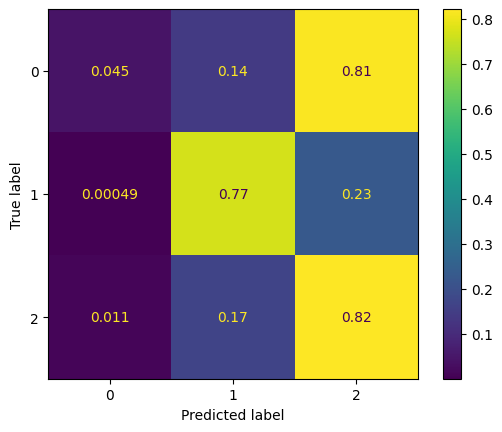

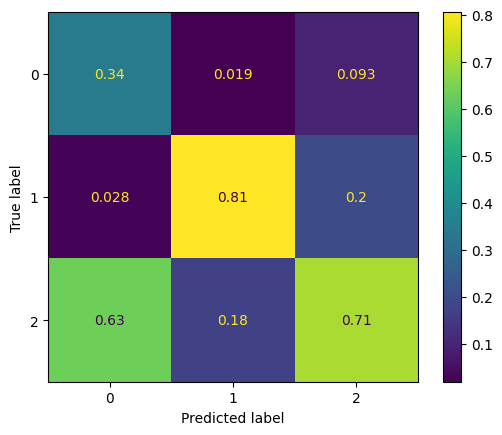

In [18]:
with torch.no_grad():
    y_pred = ironman.forward(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='true');

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, normalize='pred');


print(classification_report(y_true=y_true, y_pred=y_pred));


### **Training with Mini Batches** 📊

We can see that we did better with the mini batches, as expected. 

I won't go into the detailed reasons why just yet—that's what the PDF for Lesson 04 is for. This was just to demonstrate the code for using batches.

But I'll leave you with this thought: batching is not just about computational efficiency, it's also about improving model performance by stabilizing the training process. 📈💡

> "Baking a mini chocolate chip batch is a reminder that the sweetest moments {great learing} often come in the smallest bites."